# Lab 4


In this lab,  we will be diving into the fundamentals of analyzing and comparing text and covering the following topics:

1. On Zipf's law and Zipfian distributions, and the hapax legomenon
2. Ngrams and text pre-processing, tokenization, featurization, more collocation
3. Observing differences between text using the scattertext library

In [34]:
import os
import sys
sys.path.append('..')

import lzma
import json

import re
import itertools
import collections

import pandas as pd

from config import settings_base as settings
from config import utils

# Part 1 -Text pre-processing, tokenization, featurization

##  Tokenization 

As you might've noticed, the text data we are dealing with is mostly **strings**. There are a couple of problems with this:

* As you can imagine, a computer is not really able to "understand" what a "word" (or token). This is because in a "string", a whitespace is just another substring. To a computer, all letters and spaces are meaningless - it's just information to store.
* Thus, in order to ensure that we can parse the string, we must first identify the "words" (or tokens) in it. This is called [**tokenization**](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)
* In simplistic terms, tokenization is when we're trying to put some units of text (whether words or sentences) as items in a list.
* Now that we know what the purpose of tokenization is, we can read the wikpiedia definition: "Tokenization is the process of demarcating and possibly classifying sections of a string of input characters. The resulting tokens are then passed on to some other form of processing. The process can be considered a sub-task of parsing input."
* Furthermore, tokenization is usually an important step __prior__ to any text analysis that we do. For example, last Lab, we saw how "Phrasemachine" __only works with tokenized text__. 
* Thus, tokenization can also be thought of as one of the first steps on __pre-processing__ text - ie trying to find words in an unstructured string. 
* This goes back to the data structure distinction (between strings and lists for example) that we covered in Lab 2. Some libraries can work with strings, but others require tokenization (a list of words) as input. When we think about it, this is just another way of and __inputting__ text into some function. 
* 

To understand tokenization better, let's try a simple example

In [ ]:
sample_string = "The quick brown fox jumps over the lazy dog."
sample_string

 Now let's lowercase this string.

In [ ]:
text_lower = sample_string.lower() # lowercase 
text_lower

The simplest heuristic we can apply to tokenization is to use **"whitespace tokenizsation"** - meaning that every time a computer sees a whitespace, it will split the string. Let's try that:

In [ ]:
# Tokens
tokens = text_lower.split() # splits a string on white space
print(tokens)

One of the problems with this simplistic approach is that punctuations can be preserved as parts of tokens. Note the last word - "dog." Thus, the word is not "dog" but "dog." - even though to humans this might not seem like a big difference, but to a computer these two words are completely different. 

In [ ]:
tokens[-1] # the last element of the list

**Thus, we can try to remove punctuation entirely.** But it's important to note that we will be losing some important information - and ideally we want to preserve as much as possible (but it also depends!)



There are many ways of removing punctuation. For example, we can use a Regular Expression tokenizer which matches a pattern which captures **only words** - click on this [regex pattern](https://regexr.com/6sfat). Note that because we match only words (**\w+**), the dot is not captured by the pattern.

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize(text_lower)

We can also use libraries for this - for instance, gensim. But the key point is there are many ways of doing these things.

In [ ]:
from gensim.parsing.preprocessing import strip_punctuation

no_punctuation = strip_punctuation(text_lower)
no_punctuation

As you can see, the string doesn't have a dot. Now we can again use the simple "split" syntax to split on whitespace.

In [ ]:
no_punctuation.split()

What about numbers? Let's change the string a little bit.

In [ ]:
text_with_numbers = "these 2 quick brown foxes jump over those 20 lazy dogs"

In [ ]:
tokens = text_with_numbers.split()
print(tokens)

Below we'll use a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) which gives a convenient way of creating a list out of an existing list.

In [ ]:
# Numbers
# remove numbers (keep if not a digit)
# Here - we're using a "list comprehension"
no_numbers = [t for t in tokens if not t.isdigit()]
print(no_numbers )

In [ ]:
# keep if not a digit, else replace with "#"
norm_numbers = [t if not t.isdigit() else '#' 
                for t in tokens ]
print(norm_numbers)

## Stopwords

Another key concept that comes up when we deal with pre-processing is the so-called "stopwords" removal - words like "the", "and" etc. A word like "the" for example has no fundamental semantic meaning other than being a grammatical definite article.

But note - **just because we remove the word *the*, doesn't mean it's not informative.** In fact, many of these stop words are incredibly important, but for the purposes of simple counting and calculations, they can be removed, at least, in theory. 

In [ ]:
# Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
stoplist = stopwords.words('english') 
print ("stop words:", stoplist)

In [ ]:
# keep the words if not a stopword
nostop = [t for t in tokens if t not in stoplist] # list comprehension
print(nostop)

There are different packages with different stopword lists. 

Here's an example from **scikit-learn**


In [ ]:
# scikit-learn stopwords
# depending on sklearn version, for sklearn==0.24.1, stop_words are here
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS as stop_words
print(sorted(list(stop_words))[:20]) #first 20 stopwords


**Gensim** stopwords removing function:

In [ ]:
# gensim stopwords
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

remove_stopwords("Better late than never, but better never late.")

**Spacy** stopwords

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
print(sorted(list(nlp.Defaults.stop_words))[:30])

For the more CS-minded folks, stopword removal can also be thought of as __"dimensionality reduction"__ - more on this in the next lab. 

## Stemming 

Stemming is reducing a word to its stem or root. For example, according to the [SnowballStemmer documentation](https://pypi.org/project/snowballstemmer/), "the English stemmer maps "connection", "connections", "connective", "connected", and "connecting" to **connect**."

In [ ]:
## recall our token list
print(tokens)

In [ ]:
# Stemming
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english') # snowball stemmer, english

In [ ]:
# remake list of tokens, replace with stemmed versions
tokens_stemmed = [stemmer.stem(t) for t in tokens]
print("Unstemmed tokens: \n",tokens)
print("Stemmed tokens: \n", tokens_stemmed)

## Lemmatizing

Lemmatizing is closely related to stemming, with the difference being that we reduce the word to its "lemma" rather than its "stem." A lemma is a more fundamental base form of a word. The difference is subtle, but a good example from wikipedia is:

* The word **"better"** has **"good"** as its lemma. 
* [Spacy](https://spacy.io/usage/spacy-101#features) gives the following examples: Assigning the base forms of words. For example, the lemma of **“are”** is **“be”**, and the lemma of **“rats”** is **“rat”.**
* This link is missed by stemming - lemmatizing requires knowledge about the __Part of Speech__ tags of the word and the words around the word (whether a word is surrounded by Nouns or Verbs), and is thus a bit more intricate than stemming. 
* Therefore, lemmatization is related to stemming in that they are both methods for **normalizing text** - ie making the text more "standard", where it doesn't matter that you use "are" or "is" - both are reduced to "be."
* Depending on the context, one can prefer to lemmatize or stem their text (but usually, lemmatization is preferred - but again, it depends) 




In [ ]:
text_lower = 'these 2 brown foxes are better than 20 dogs'

In [ ]:
doc = nlp(text_lower)

for token in doc:
    print(token, token.pos_, token.lemma_)

Note: Keep in mind that POS tagging itself is not ideal, as the example below shows.

In [ ]:
text_lower = 'hurt people hurt people'

In [ ]:
doc = nlp(text_lower)

for token in doc:
    print(token, token.pos_, token.lemma_)

## Sentence tokenization


Tokenizing sentences is just like tokenizing words - the difference being is that each item in a list is going to be a sentence rather than a token. This is useful - sometimes, for your research purposes, the __unit of analysis__ might be sentences and not individual words.

Let's modify our running example a little bit by adding a quote from David Foster Wallace 

In [ ]:
text = "The quick brown fox jumps over the lazy dog. And yet: why not be someone who stays up all night torturing himself mentally over the question of whether or not there's a dog?"
print(text)

Let's try nltk's sentence tokenizer

In [ ]:
nltk.download('punkt')
from nltk import sent_tokenize

In [ ]:
sentences = sent_tokenize(text) ### sentence tokenization
sentences

Now let's try spacy's sentence tokenization

In [ ]:
doc = nlp(text)
sentences = list(doc.sents)
sentences

Although the outputs are the same, what's going on behind the scenes is not. 
You should note that the `spacy` sentence tokenization is based on a nlp model (which we call using `nlp()` syntax - and this model takes into account more information that `nltk`'s sentence tokenizer.

* Thus, spacy be good if you want good quality sentences
* But since it's a bit more complex, it's computationally more expensive, and thus could take longer than nltk

# Part 2 - Comparing texts  




In this lab, we will be investigating cases from the state of **Delaware**. 

As we will find out, Delaware is a pretty interesting jurisdiction when it comes to US Law - and we will try to demonstrate why Delaware is so unique in this lab using text comparison techniques.

To extract cases, we will again use the case.Law API.

In [2]:
compressed_file = utils.get_and_extract_from_bulk(jurisdiction = "Delaware", 
                                                  data_format="json")


In [4]:
#If you downloaded the file you can also use the following code:
compressed_file = utils.get_cases_from_bulk(jurisdiction="Delaware", data_format="json")


downloading Delaware-20200302-text.zip into ../data dir


57900it [00:04, 14189.54it/s]


extracting Delaware-20200302-text.zip into ../data dir
Done.


In [5]:
cases = []
print("File path:", compressed_file)
with lzma.open(compressed_file) as infile:
    for line in infile:
        record = json.loads(str(line, 'utf-8'))
        cases.append(record)

print("Case count: %s" % len(cases))

File path: C:\Users\ilyaa\Desktop\GitHub\LEGAL-190-FA22 - BACKUP\Lab 4\config\../data\Delaware-20200302-text/data/data.jsonl.xz
Case count: 16772


Again, if you want to limit the amount of cases you look at, you can use the code from last lab to do that.

In [6]:
df = pd.DataFrame(cases)
df.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,reporter,court,jurisdiction,frontend_url,preview,casebody
0,11737169,https://api.capapi.org/v1/cases/11737169/,In the Matter of Ronald L. CANTRELL for a Writ...,In re Cantrell,1996-07-01,"No. 258, 1996",525,526,"[{'type': 'official', 'cite': '678 A.2d 525'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/678/525/,[],"{'data': {'judges': ['Before WALSH, HOLLAND, a..."
1,11684804,https://api.capapi.org/v1/cases/11684804/,"Hendrik LIKET, Defendant Below, Appellant, v. ...",Liket v. State,1998-11-04,"No. 286, 1997",935,939-941,"[{'type': 'official', 'cite': '719 A.2d 935'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/719/935/,[],"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
2,11684732,https://api.capapi.org/v1/cases/11684732/,"STATE of Delaware, Employer Below, Appellant, ...",State v. Steen,1998-10-22,"No. 57, 1998",930,935,"[{'type': 'official', 'cite': '719 A.2d 930'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/719/930/,[],"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
3,11637715,https://api.capapi.org/v1/cases/11637715/,"Eric BARKLEY, Defendant Below, Appellant, v. S...",Barkley v. State,1999-02-19,"No. 116, 1998",558,561,"[{'type': 'official', 'cite': '724 A.2d 558'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/724/558/,[],"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
4,11638241,https://api.capapi.org/v1/cases/11638241/,"S&R ASSOCIATES, L.P., III, a Limited Partnersh...","S&R Associates, L.P. v. Shell Oil Co.",1998-09-30,No. 94C-06-189-WTQ,431,440,"[{'type': 'official', 'cite': '725 A.2d 431'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/725/431/,[],"{'data': {'judges': [], 'attorneys': ['Stephan..."


In [8]:
df = df[['name_abbreviation', 'decision_date', 'court', 'casebody' ]]
df.head()

,name_abbreviation,decision_date,court,casebody
0,In re Cantrell,1996-07-01,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before WALSH, HOLLAND, a..."
1,Liket v. State,1998-11-04,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
2,State v. Steen,1998-10-22,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
3,Barkley v. State,1999-02-19,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
4,"S&R Associates, L.P. v. Shell Oil Co.",1998-09-30,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Stephan..."


In [10]:
# Helper function to extract the main text in casebody column
def get_text(x):
    if len(x['data']['opinions'])>0:
        return x['data']['opinions'][0]['text']
    else:
        return 0

# Helper function to remove punctuations in text 
def remove_punctuation(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", 
                           " ", 
                           txt).split())

## Delaware Court of Chancery vs Delaware Court of Common Pleas

In the cells below, we will create a a new column called __"court_name"__ which will indicate the name of the Court in the State of Delaware. We are particularly interested in comparing words between the **"Delaware Court of Chancery"** and the **"Delaware Court of Common Pleas"**

* According to the website description of their jurisdiction, the [**"Delaware Court of Common Pleas"**](https://courts.delaware.gov/commonpleas/jurisdiction.aspx) deals with both criminal and civil issues. You can read the details of cases it hears on their website.
* On the other hand, the [**"Delaware Court of Common Pleas"**](https://courts.delaware.gov/chancery/jurisdiction.aspx) website states that "The Delaware Court of Chancery is widely recognized as the nation's preeminent forum for the determination of disputes involving the internal affairs of the thousands upon thousands of Delaware corporations and other business entities through which a vast amount of the world's commercial affairs is conducted. Its unique competence in and exposure to issues of business law are unmatched" - this actually interestingly sounds like an advertisement. 

In [12]:
df.head()

,name_abbreviation,decision_date,court,casebody
0,In re Cantrell,1996-07-01,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before WALSH, HOLLAND, a..."
1,Liket v. State,1998-11-04,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
2,State v. Steen,1998-10-22,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
3,Barkley v. State,1999-02-19,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
4,"S&R Associates, L.P. v. Shell Oil Co.",1998-09-30,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Stephan..."


The Court information is contained the "court" column

In [13]:
df['court'][0]

{'url': 'https://api.capapi.org/v1/courts/del-2/',
 'name_abbreviation': 'Del.',
 'slug': 'del-2',
 'name': 'Delaware Supreme Court',
 'id': 9322}

To extract the "court_name", we need to go into this dictionary and use the "name" key.

In [14]:
df['court_name'] = df["court"].apply(lambda x:x['name'])

We now need to conditionally select only those court names that are "Delaware Court of Chancery" and "Delaware court of common pleas" - and create separate dataframes out of them. 

In [19]:
common_pleas = df[df['court_name'] == 'Delaware Court of Common Pleas'] 
common_pleas.head()

,name_abbreviation,decision_date,court,casebody,court_name
1106,Waples v. Waples,1798-11-22,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Wilson ...",Delaware Court of Common Pleas
1107,Babb v. Perkins,1795,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Levy, B...",Delaware Court of Common Pleas
1110,Gillaspy v. Garrat,1805-12,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Bayard ...",Delaware Court of Common Pleas
1113,Pemberton v. Nixon,1794-05,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Mr. Bay...",Delaware Court of Common Pleas
1115,Smack v. Battle,1803-12-08,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Ridgely...",Delaware Court of Common Pleas


In [20]:
len(common_pleas)

275

In [21]:
chancery = df[df['court_name'] == 'Delaware Court of Chancery'] ## create a new dataframe called "chancery" which is a conditional subset
chancery = chancery.sample(275) ## random sample of 275 chancery cases - since common pleas has only 275 cases

In [22]:
chancery.head()

,name_abbreviation,decision_date,court,casebody,court_name
7902,Delaware Trust Co. v. Young,1952-12-24,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['David F...",Delaware Court of Chancery
15837,Sonet v. Timber Co.,1998-12-16,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Joseph ...",Delaware Court of Chancery
8092,Sussex Trust Co. v. Polite,1918-06-17,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Joseph ...",Delaware Court of Chancery
8837,Adams v. Clearance Corp.,1955-09-28,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['John Va...",Delaware Court of Chancery
3300,Bruce v. E. L. Bruce Co.,1961-09-19,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Alexand...",Delaware Court of Chancery



Now we can concatenate both of these dataframes. 

In [24]:
concat = pd.concat([chancery, 
                    common_pleas]) ## create new dataframe called "concat"

Now that we have a dataframe with __only__ the Chancery and the Common please decisions, we can run the following cell which applies the **"get_text"** function that we created above, to the "case_text" column using pandas [apply function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)

In [25]:
concat['case_text'] = concat['casebody'].apply(lambda x: get_text(x)) ## use the function we created above called "get_text" 
                                                                      ## which will extract the text
concat = concat[concat['case_text'] != 0]

If you want to remove punctuation you can run the following cell which applies the "remove_punctuation" function to the "case_text" column, again, using lambda apply syntax

In [26]:
concat['case_text'] = concat['case_text'].apply(lambda x:remove_punctuation(x))

In [27]:
concat.head()

,name_abbreviation,decision_date,court,casebody,court_name,case_text
7902,Delaware Trust Co. v. Young,1952-12-24,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['David F...",Delaware Court of Chancery,Bramhall Vice Chancellor Edith Bryan Quillen d...
15837,Sonet v. Timber Co.,1998-12-16,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Joseph ...",Delaware Court of Chancery,MEMORANDUM OPINION CHANDLER Chancellor This di...
8092,Sussex Trust Co. v. Polite,1918-06-17,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Joseph ...",Delaware Court of Chancery,The Chancellor The legal position taken by the...
8837,Adams v. Clearance Corp.,1955-09-28,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['John Va...",Delaware Court of Chancery,Marvel Vice Chancellor The individual plaintif...
3300,Bruce v. E. L. Bruce Co.,1961-09-19,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'data': {'judges': [], 'attorneys': ['Alexand...",Delaware Court of Chancery,Marvel Vice Chancellor Plaintiffs together own...


# Part 3 - Differences between texts - exploratory data analysis 


We are going to use scattertext to visualize text comparisons. You can take a case from Delaware court of Chancery vs Delaware Criminal court for example - https://github.com/JasonKessler/scattertext

In [ ]:
#!pip install scattertext
import scattertext as s

In [ ]:
concat['case_parse'] = concat.case_text.apply(st.whitespace_nlp_with_sentences)

In [ ]:
corpus = st.CorpusFromParsedDocuments(
    concat, category_col='court_name', parsed_col='case_parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

In [ ]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Delaware Court of Chancery', category_name='Delaware Court of Chancery', not_category_name='Delaware Court of Common Pleas',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000, metadata=corpus.get_df()['name'],
    transform=st.Scalers.dense_rank
)

In [ ]:
open('./case.html', 'w').write(html)

In [ ]:
import IPython
IPython.display.HTML(filename='./case.html')

## Shifterator

[Shifterator](https://shifterator.readthedocs.io/en/latest/cookbook/getting_started.html#case-study) is a pretty cool recent package which helps us intuitively understand and visualize the classical question of "comparing texts" - in the words of the creators "word shift graphs are interpretable horizontal bar charts for visualizing how any two texts compare according to a given measure."  

* Firstly, there are a number of different __measures__ that are discussed in the paper. From relative frequencies of words to "Jensen-Shannon divergence" - which is actually pretty commonly used in NLP. For the purposes of the class, it's not important to know the __math__ behind these measures - what's important is that some measures have certain benefits over others - and thus, visualizations will come out different. Essentially, all they do is show difference between texts. 
* The data input that it expects is a frequency count of words in a given text - and the `clean_text` function below does just that.



In [28]:
#!pip install shifterator
import shifterator as sh

In [35]:
from gensim.parsing.preprocessing import remove_stopwords

def clean_text(text_list):
    temp = [remove_stopwords(individual_text.lower()) for individual_text in text_list]      # lowercase and  gensim's remove stopwords 
    temp = [individual_text.split() for individual_text in temp]                        # lowercase and tokenize the cases 
    temp = list(itertools.chain(*temp))
    temp = collections.Counter(temp)
    return temp

Let's now clean the text and create a counter object (frequency of words), which is required to work with shifterator

In [36]:
clean_texts_chancery = clean_text(concat[concat['court_name'] == 'Delaware Court of Chancery']['case_text'].to_list())
clean_texts_pleas = clean_text(concat[concat['court_name'] == 'Delaware Court of Common Pleas']['case_text'].to_list())

Now that we have our data in the appropriate format for the shifterator, we can try to examine the different measures shifterator provides. 

* The [shifterator cookbook](https://shifterator.readthedocs.io/en/latest/cookbook/index.html) goes over these in great detail. 
* Keep in mind that once we have the data, we don't need to make it again. 
* Also, even though I removed the stopwords, technically, this is not necessary as some measures (like the shannon entropy shift) can safely ignore stopwords. But I did that just in case.


Let's start with the __proportion frequency shift__ 

C:\Users\ilyaa\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


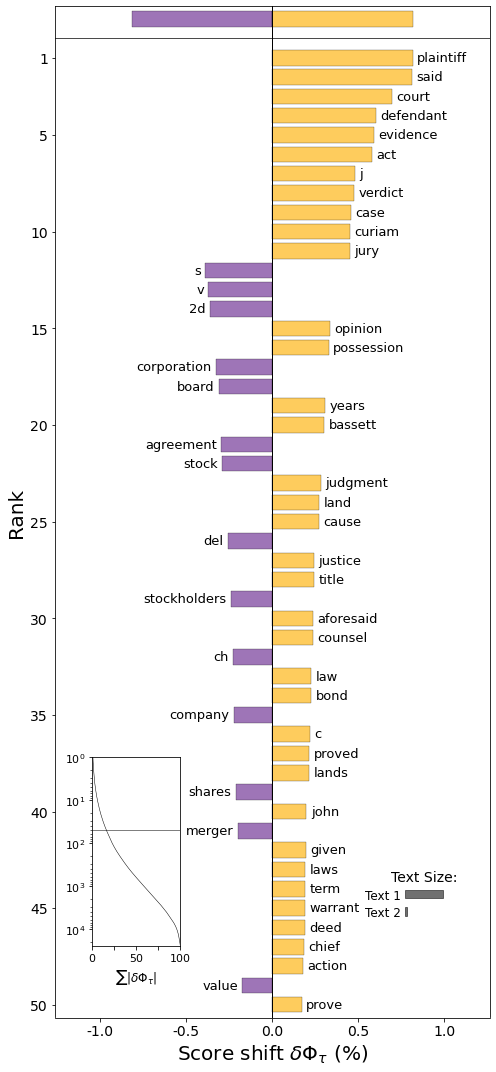

In [37]:
proportion_shift = sh.ProportionShift(type2freq_1 = clean_texts_chancery,
                                      type2freq_2 = clean_texts_pleas)
proportion_shift .get_shift_graph(); 

C:\Users\ilyaa\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


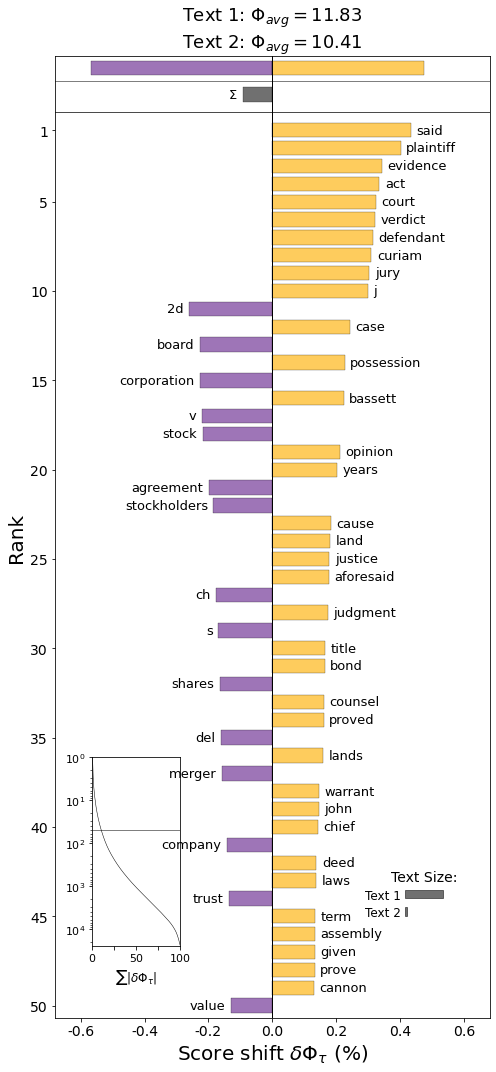

In [39]:
entropy_shift = sh.EntropyShift(type2freq_1 = clean_texts_chancery, 
                                type2freq_2 = clean_texts_pleas, base=2)
entropy_shift.get_shift_graph(); 

C:\Users\ilyaa\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


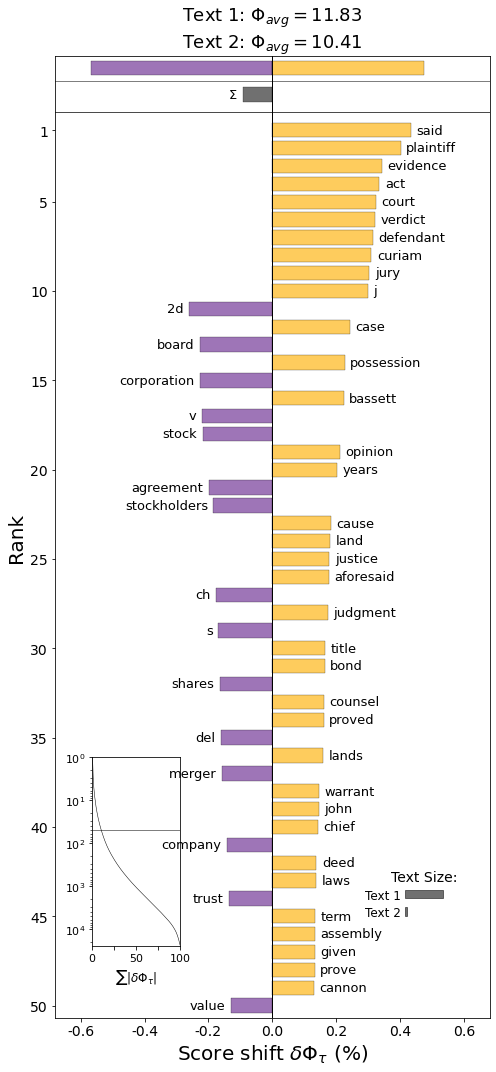

In [42]:
jsd_shift = sh.JSDivergenceShift(type2freq_1 = clean_texts_chancery,
                                 type2freq_2 = clean_texts_pleas,
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)

entropy_shift.get_shift_graph(); 

Do you see any differences between these measures? What words are emphasized?

In order to answer this, you have to read the brief explanation that is provided in the [shifterator cookbook](https://shifterator.readthedocs.io/en/latest/cookbook/frequency_shifts.html#jensen-shannon-divergence-shifts)

## Scattertext


We are going to use [scattertext](https://github.com/JasonKessler/scattertext) to visualize text comparisons. You can take a case from Delaware court of Chancery vs Delaware Criminal court for example.

Note: scattertext is more taxing than a simple measure like "Jensen Shannon Divergence" - so use it on small/medium corpuses.

In [43]:
#!pip install scattertext
import scattertext as st

To work with scattertext we'll need two things:

* A column that labels our data into two distinct classes - in this case `__court_name__` - because we care about the distinction between Chancery (1) vs Please (0)
* Spacy's NLP model - which is why this might take a bit of a while 

In [47]:
import spacy
nlp = spacy.load('en_core_web_sm')

corpus = st.CorpusFromPandas(concat,
                             category_col='court_name',
                             text_col='case_text',
                             nlp = nlp).build()

Words associated with the Chancery Court

In [51]:
list(corpus.get_scaled_f_scores_vs_background().index[:10])

['stockholders',
 'ibp',
 'stockholder',
 'plaintiffs',
 'plaintiff',
 'defendants',
 'tyson',
 'pendum',
 'minera',
 'fiduciary']

In [55]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['chancery score'] = corpus.get_scaled_f_scores('Delaware Court of Chancery')

In [57]:
print(list(term_freq_df.sort_values(by='chancery score', ascending=False).index[:10]))

['a 2d', 'stock', '2d', 'stockholders', 'del ch', 'merger', 'inc', 'the board', 'complaint', 'tyson']


Import some libraries to display HTML

In [99]:
from IPython.core.display import display, HTML
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%matplotlib inline

Produce HTML file - note that the parameters set here can determine how the visualization looks like - in particular "minimum_term_frequency" and "pmi_threshold_coef"

In [98]:
html = st.produce_scattertext_explorer(corpus,
          category='Delaware Court of Chancery',
          category_name='Chancery',
          not_category_name='Pleas',
          minimum_term_frequency = 10, 
          pmi_threshold_coefficient = 8,
          #transform=st.Scalers.dense_rank, 
          width_in_pixels=1000)

In [101]:
file_name = 'chancery_vs_pleas.html'         
with open(file_name, 'wb') as fn:
    fn.write(html.encode('utf-8'))              

display(IFrame(file_name, width=1000, height=650))